<h1><center>Proyecto final</center></h1>


<h2><center>Cómputo conexionista (A21)</center></h2>

---

<h3><center>

José Ángel Avelar Barragan (A200361)

José de Jesús Daniel Aguirre Arzate (A200350)
</center></h3>

---

<center><h2>"Identification of patterns in cosmic-ray arrival directions using dynamic graph convolutional neural networks"</center></h2>

---

Como proyecto final nos propusimos intentar entender el articulo y tratar de replicar los resultados. A la par intentamos relacionar los conceptos vistos en clase con lo que hace el articulo. Como primer objetivo tuvimos que entender como se estan procesando los datos y como objetivo final intentar construir la red que ellos proponen (tensorflow/pytorch).

#### Montado de Drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive




## <h2><center>Teoria</center></h2>

---

### **Problema:**
A traves de los patrones en las direcciones de arrivo de las particulas, distingir rayos cosmicos que vienen de la misma fuente o de un fondo isotropico (ruido de fondo).

Este metodo intenta encontrar patrones en las direcciones de arrivo de rayos cosmicos, si existen patrones se calsifica a las particulas como las que vienen de una fuente comun y las que vienen de direcciones de arribo isotropicas.

Datos de entrenamiento: Simulaciones simples de direcciones de arribo donde se conoce la unica fuente que genera algunos rayos cosmicos(+ detalles en el articulo acerca de la configuracion del simulador BENCHMARK1)

![Simulated arrival directions](images/skymap_0.png)


### Bloque de imports

In [15]:


import numpy as np
import scipy
import matplotlib.pyplot as plt

import os
import time
import pickle

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as lay

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.5.0


In [16]:
#Intentando usar astrotools
try:
    import astrotools
    from astrotools import auger, coord, skymap
except ModuleNotFoundError: 
    print("Instalandolo entonces\n")
    !pip install healpy
    !pip install astrotools
from astrotools import skymap


Instalandolo entonces

     |████████████████████████████████| 18.1MB 1.5MB/s 
     |████████████████████████████████| 18.9MB 40.8MB/s 


<h2><center>Preparacion de datos</center></h2>

---

El dataset *dataset_HAP.npz* esta organizado de la siquiente manera:

Un diccionario con las keys: data, label
En las cuales en data esta un arreglo de 50000 simulaciones de 500 particulas cada una con sus respectivas coordenadas (x,y,z, E) donde E es la energia normalizada. 

Y el arreglo que viene en label clasifica a 1 como aaquellas simulaciones que tienen una fuente o 0 como aquellas que solo son arrivos isotropicos. 

In [17]:
!ls "/content/drive/MyDrive/Proyecto/data/cosmic_ray_sphere" #Path de José Ángel


dataset_HAP.npz


In [18]:
dir ="/content/drive/MyDrive/Proyecto/data/cosmic_ray_sphere/"

In [19]:
#Ruta de Jose para edgeConv.py
dir2 =  "/content/drive/MyDrive/Colab Notebooks/"

In [20]:
def deflected_cosmic_rays():
    file = np.load(dir+"dataset_HAP.npz")
    x_train, x_test = file["data"][:-10000], file["data"][-10000:]
    labels = tf.keras.utils.to_categorical(file["label"],num_classes=2)
    y_train, y_test = labels[:-10000], labels[-10000:]
    return x_train, x_test, y_train, y_test

In [21]:
#Demora unos segundos
X_train, X_test, y_train, y_test = deflected_cosmic_rays()

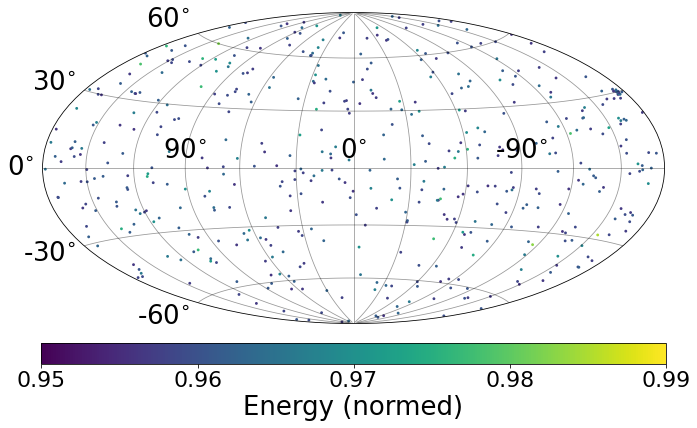

<Figure size 864x432 with 0 Axes>

In [22]:
test_id = 0
example_map = X_test[0]
skymap.eventmap(example_map[:,0:3].T, c=example_map[:,3], cblabel='Energy (normed)', opath="skymap_%i.png" % test_id)
im = Image.open("skymap_0.png")
im

In [23]:
train_points, test_points, train_features, test_features = X_train[...,:3], X_test[...,:3], X_train[...,-1, np.newaxis], X_test[...,-1, np.newaxis]
train_input_data, test_input_data = [train_points, train_features],[test_points, test_features]

### EdgeConv 
La convolución de aristas se basa en obtener caracteristicas invariantes a la permutación de la geometria local de un grafo, en lugar de obtenerlas de los embbedings del mismo. \
En particular se trata de un invariante al reordenamiento de los vecinos, ya que la función *construye* un grafo local y extrae los embedings de las aristas.

### K-nn
Para poder construir un grafo local se implementa el método de K-nn dónde el grafo generado depende del número de vecinos de cada nodo tales que estos sean los que están más cerca de este. \
En esta implementación se emplea el cálculo de la distancia euclideana entre los puntos y la misma capa convolucional realiza esta operación.

### $h_\Theta$ Función no lineal del mensaje

En este caso la función encargada de la no linealidad del mensaje es una MLP (detallada en arquitectura), esta también cumple con ajustar el tamaño del mensaje modificando así el número de caracteristicas asociados a cada nodo por capa de edgeConv. 

$$ h_{\theta} (x_{i,c},x_{i_j,c})= NN_\theta ( x_{i,c} , x_{i,c} - x_{i_j,c} )$$

### Agregación

La agregación del mensaje se hace por cada vecino que nos devuelve un mensaje, siendo descrita como:

$$ x_{i,c}' = \frac{1}{k_n} \sum \ h_{\theta}(x_{i,c},x_{i_j,c})$$

Notemos que este paso incluye al nodo central como parte del mensaje  *self-loop* pero concatena las caracteristicas del nodo con las caracteristicas de arista para obtener un nuevo vector enriquesido de caracteristicas que pasaran a la siguiente capa.



### Dynamic Graph

Se considera que la implementación es un gráfo dinámico ya que tras cada iteración se extiende el vector de coordenadas con las caracteristicas obtenidas por la capa previa, de forma que el k-nn formado por cada capa difiere del anterior. \
Presumimos que aquellos más similares se aproximarán en cada iteración, como se ilustra en: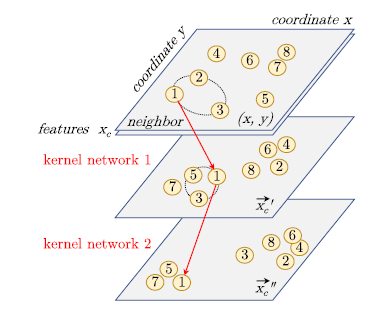


### Modelo completo
A continuación se declaran algunas de las caracteristicas y detalles de la arquitectura en cuestión:
- Separación de las entradas y aplicación de BatchNorm a las Caracteristicas (Energía)
- Incersión de las Coordenadas, concatenandolas con las caracteristicas antes de cada EdgeConv
- Aplicación de 3 EdgeConv, con unidades ReLU, 16 vecinos y  16,32 y 64 nodos en sus capas Densas respectivamente.
- GlobalAveragePooling, para emplear capas Densas
- Dos capas densas de 256 y 2 unidades con ReLU y SoftMax como activación.
- BatchNorm con momento 0.9 y $\epsilon \ 10^{-5}$
- Optimizador Adam, con Lr variable (decaimiento de $10^{-3}$ a $10^{-5}$ y decaimiento coseno)
- Metricas: Entropía Cruzada Categorica y Presición

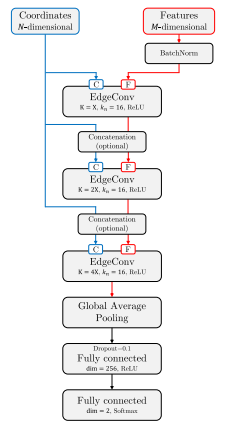
 

## <h2><center>Implementacion</center></h2>

---

 
- <h3>Tensorflow</h3>

#### Importando edgeConv

In [11]:
os.chdir(dir2)

In [12]:
from edgeConv import EdgeConv

José de Jesus

In [13]:
MODEL = tf.keras.models.Model
LAYERS = tf.keras.layers
NODES = 16

def kernel_nn(data, nodes=NODES):
    d1, d2 = data

    delta = LAYERS.Subtract()([d1,d2])
    x = LAYERS.Concatenate(axis=-1)([d1,delta])

    x = LAYERS.Dense(nodes, activation="relu")(x)
    x = LAYERS.BatchNormalization()(x)

    x = LAYERS.Dense(nodes, activation="relu")(x)
    x = LAYERS.BatchNormalization()(x)

    x = LAYERS.Dense(nodes, activation="relu")(x)
    x = LAYERS.BatchNormalization()(x)
    return x  

from edgeConv import EdgeConv
class DGCNN(MODEL):

    def __init__(self):
        super(DGCNN, self).__init__()

        self.HL1 = EdgeConv(lambda a: kernel_nn(a,nodes=8), next_neighbors=5)
        self.HL2 = EdgeConv(lambda a: kernel_nn(a,nodes=16), next_neighbors=8)
        self.HL3 = EdgeConv(lambda a: kernel_nn(a,nodes=32), next_neighbors=16)
        self.out = LAYERS.Dense(2, activation="softmax")
        self.ReLu = LAYERS.Activation("relu")
        
        self.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(3E-3, decay=1E-4),metrics=['acc'])
    
    def call(self,train_arr):
        points_in, feats_in = train_arr

        l1 = self.HL1([points_in, feats_in]) # (None, 500, 8) 
        l1 = self.ReLu(l1)

        l2 = self.HL2([points_in, l1]) # (None, 500, 16) 
        l2 = self.ReLu(l2)

        l3 = self.HL3([points_in, l2]) # (None, 500, 32) 
        l3 = self.ReLu(l3)
        l3 = LAYERS.GlobalAveragePooling1D(data_format='channels_first')(l3)

        out = self.out(l3) # (None, 2) 
        return out





In [14]:
model = DGCNN()
points_in, feats_in= LAYERS.Input((500,3)), LAYERS.Input((500,1))
model.build([points_in.shape, feats_in.shape])
model.summary()

Model: "dgcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
edge_conv (EdgeConv)         multiple                  264       
_________________________________________________________________
edge_conv_1 (EdgeConv)       multiple                  1008      
_________________________________________________________________
edge_conv_2 (EdgeConv)       multiple                  3552      
_________________________________________________________________
dense (Dense)                multiple                  1002      
_________________________________________________________________
activation (Activation)      multiple                  0         
Total params: 5,826
Trainable params: 5,490
Non-trainable params: 336
_________________________________________________________________


In [15]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(3E-3, decay=1E-4),metrics=['acc'])

BATCH_SIZE = 64
EPOCHS     = 10
hist = model.fit(train_input_data, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/10
625/625 [==============================] - 151s 232ms/step - loss: 0.5764 - acc: 0.6487
Epoch 2/10
625/625 [==============================] - 149s 238ms/step - loss: 0.4348 - acc: 0.7948
Epoch 3/10
625/625 [==============================] - 150s 240ms/step - loss: 0.3932 - acc: 0.8214
Epoch 4/10
625/625 [==============================] - 150s 240ms/step - loss: 0.3763 - acc: 0.8312
Epoch 5/10
625/625 [==============================] - 150s 240ms/step - loss: 0.3626 - acc: 0.8398
Epoch 6/10
625/625 [==============================] - 150s 240ms/step - loss: 0.3533 - acc: 0.8458
Epoch 7/10
625/625 [==============================] - 150s 239ms/step - loss: 0.3462 - acc: 0.8489
Epoch 8/10
625/625 [==============================] - 150s 239ms/step - loss: 0.3408 - acc: 0.8521
Epoch 9/10
625/625 [==============================] - 149s 239ms/step - loss: 0.3361 - acc: 0.8551
Epoch 10/10
625/625 [==============================] - 150s 239ms/step - loss: 0.3305 - acc: 0.8591


In [16]:
def plot_hist(history):
    fig, axes = plt.subplots(2, figsize=(12,8))
    if type(history) == dict:
        loss = history["loss"]
        acc = history["acc"]
    else:
        loss, acc = np.split(np.array(history), 2, axis=-1)
    x = np.arange(len(loss))
    axes[0].plot(x, loss, c="navy")
    axes[0].set_yscale("log")
    axes[0].set_ylabel("Loss")
    axes[1].plot(x, acc, c="firebrick")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_ylim(0, 1)
    if type(history) == dict:
        axes[0].set_xlabel("Epochs")
        axes[1].set_xlabel("Epochs")
    else:
        axes[0].set_xlabel("Iterations")
        axes[1].set_xlabel("Iterations")
    fig.tight_layout()
    return fig

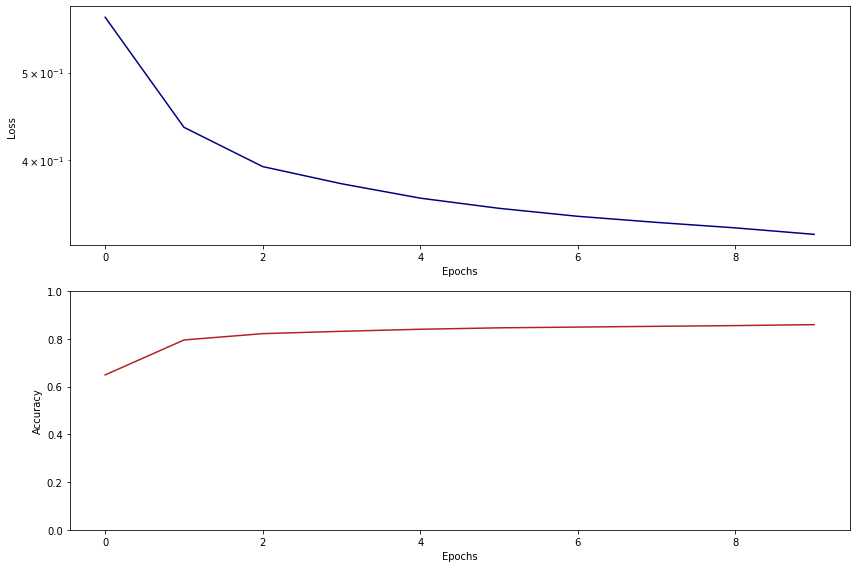

In [17]:
fig = plot_hist(hist.history)
fig.savefig("./history.png")

José Ángel

In [18]:


#para dar el shape
points = lay.Input((500, 3))
feats  = lay.Input((500, 1))

In [19]:


class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()

    self.edge1 = EdgeConv(lambda a: kernel_nn(a, nodes=16), next_neighbors=16)
    self.edge2 = EdgeConv(lambda a: kernel_nn(a, nodes=32), next_neighbors=16)
    self.edge3 = EdgeConv(lambda a: kernel_nn(a, nodes=64), next_neighbors=16)
    self.drop1  = lay.Dropout(0.1)
    self.batch1 = lay.BatchNormalization(momentum=0.9, epsilon=1e-5)

    
    self.GAP1D  = lay.GlobalAveragePooling1D(data_format='channels_first' )
    self.Dense1  = lay.Dense(256,activation='relu')
    self.Dense2  = lay.Dense(2,activation='softmax')

    

  def call(self, inputs):
    points,feats = inputs
    feats = self.batch1(feats)
    
    x =  self.edge1([points,feats]) 
    x =  lay.Activation("ReLU")(x)
    x =  self.edge2([points,x]) 
    x =  lay.Activation("ReLU")(x)
    x =  self.edge3([points,x]) 
    x =  lay.Activation("ReLU")(x)
    
    x  = self.GAP1D(x)
    x  = self.Dense1(x)
    x  = self.drop1(x)
    out  = self.Dense2(x)
  
    return out


In [20]:
points.shape,feats.shape # Batch, nodos, caraceristicas


(TensorShape([None, 500, 3]), TensorShape([None, 500, 1]))

In [21]:
model_C = MyModel()

In [22]:
model_C.build([points.shape,feats.shape])
model_C.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
edge_conv_3 (EdgeConv)       multiple                  784       
_________________________________________________________________
edge_conv_4 (EdgeConv)       multiple                  3552      
_________________________________________________________________
edge_conv_5 (EdgeConv)       multiple                  13248     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  4         
_________________________________________________________________
global_average_pooling1d (Gl multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  128

In [23]:
#Caída del LR
#lr_schedule = tf.keras.optimizers.schedules.CosineDecay(1e-3,decay_steps=1000)
lr_schedule = 1e-3
model_C.compile(loss= "categorical_crossentropy",metrics=["acc"], optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))


In [24]:
hist2 = model_C.fit(train_input_data, y_train, epochs=10, batch_size=64)

Epoch 1/10
625/625 [==============================] - 198s 311ms/step - loss: 0.5543 - acc: 0.6889
Epoch 2/10
625/625 [==============================] - 194s 311ms/step - loss: 0.4566 - acc: 0.7739
Epoch 3/10
625/625 [==============================] - 194s 311ms/step - loss: 0.4114 - acc: 0.8088
Epoch 4/10
625/625 [==============================] - 194s 311ms/step - loss: 0.3748 - acc: 0.8321
Epoch 5/10
625/625 [==============================] - 194s 311ms/step - loss: 0.3333 - acc: 0.8566
Epoch 6/10
625/625 [==============================] - 194s 311ms/step - loss: 0.2872 - acc: 0.8819
Epoch 7/10
625/625 [==============================] - 194s 311ms/step - loss: 0.2473 - acc: 0.9018
Epoch 8/10
625/625 [==============================] - 194s 311ms/step - loss: 0.2049 - acc: 0.9223
Epoch 9/10
625/625 [==============================] - 194s 311ms/step - loss: 0.1670 - acc: 0.9377
Epoch 10/10
625/625 [==============================] - 194s 310ms/step - loss: 0.1312 - acc: 0.9525


In [25]:
#Usando nuestros datos:
model_C.predict([ np.reshape(X_train[0,:,0:3],(-1,500,3)),np.reshape(X_train[0,:,3],(-1,500,1)) ] ), y_train[0]


(array([[6.2700775e-15, 1.0000000e+00]], dtype=float32),
 array([0., 1.], dtype=float32))

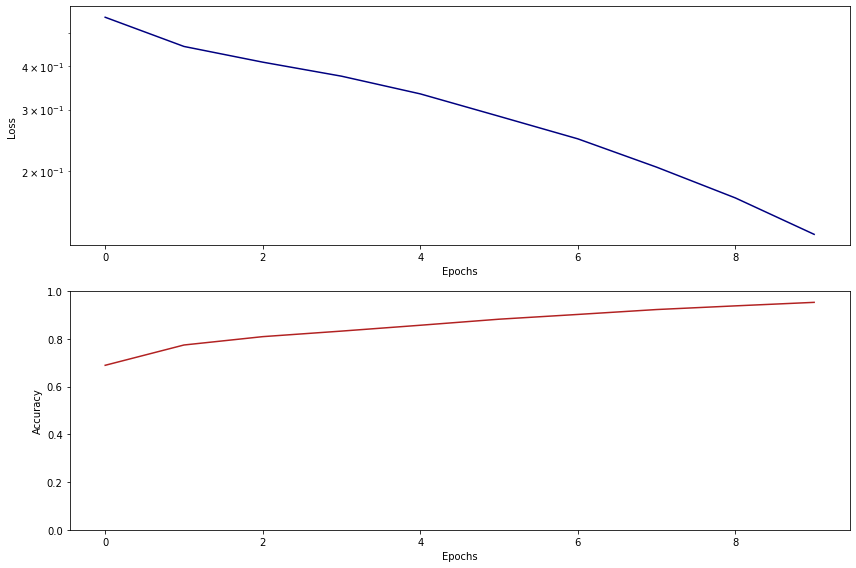

In [26]:
fig = plot_hist(hist2.history)
fig.savefig("./history2.png")

## Enlace a Git de nuestro intento de replicar:
https://github.com/gsusAguirreArz/proyectoConexionistaA21


## Referencias:

- Bister, T., Erdmann, M., Glombitza, J., Langner, N., Schulte, J., & Wirtz, M. (2021). Identification of patterns in cosmic-ray arrival directions using dynamic graph convolutional neural networks. Astroparticle Physics, 126, 102527.
https://www.sciencedirect.com/science/article/pii/S0927650520300992

- Wang, Y., Sun, Y., Liu, Z., Sarma, S. E., Bronstein, M. M., & Solomon, J. M. (2019). Dynamic graph cnn for learning on point clouds. Acm Transactions On Graphics (tog), 38(5), 1-12. \
https://dl.acm.org/doi/abs/10.1145/3326362

- EdgeConv \
https://git.rwth-aachen.de/niklas.langner/edgeconv_keras

- SOURCE CODE FOR TORCH_GEOMETRIC.NN.CONV.EDGE_CONV \
https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/edge_conv.html

Pytorch_geometric

In [5]:
import time
import sys

import torch
import torch as pt
print(f"Pytorch version: {torch.__version__}")

Pytorch version: 1.9.0+cu102


In [6]:
try:
  import torch_geometric as ptg
except ModuleNotFoundError: 
  print("Instalando entonces:\n")
  !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
  !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
  !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
  !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
  !pip install torch-geometric
  import torch_geometric as ptg

Instalando entonces:

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 2.6MB 11.7MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 1.4MB 10.7MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 931kB 12.5MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 368kB 9.9MB/s 
     |████████████████████████████████| 225kB 13.9MB/s 
     |████████████████████████████████| 235kB 26.6MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.1-cp37-none-any.whl size=381206 sha256=d6bf38846be2e60148749723f23cf1ce55cba9292e11f486888ecddbc5ec3798
  Stored in directory: /root/.cache/pip/wheels/f3/97/91/7572ed6157a4c1ccef22a91a7ae9365413b57bb1a65d6056fa
Successfully

In [7]:
from torch.nn import functional as F 
from torch.nn import Sequential as Seq
from torch.nn import BatchNorm1d as BN
from torch.nn import Linear, ReLU, Module

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import global_mean_pool

from torch_geometric.nn import MessagePassing, DynamicEdgeConv, global_max_pool, global_mean_pool
from torchsummary import summary

In [8]:
device = pt.device('cuda' if pt.cuda.is_available() else 'cpu')


In [24]:
#arreglos a tensores
train_points    = pt.tensor(X_train[...,:3]).type(pt.float32)
train_features  = pt.tensor(X_train[...,-1, np.newaxis]).type(pt.float32) 
y_train_pt      = pt.tensor(y_train.reshape(-1,1)).type(pt.long)
test_points     = pt.tensor(X_test[...,:3]).type(pt.float32)
test_features   = pt.tensor(X_test[...,-1, np.newaxis]).type(pt.float32) 
y_test_pt       = pt.tensor(y_test.reshape(-1,1)).type(pt.long)

In [25]:
#Data Loaders
N_TRAIN = X_train.shape[0]
BATCH_SIZE = 64


train_dset = [Data(pos=train_points[i],x=train_features[i], y=y_train_pt[i]) for i in range(len(train_points))]
test_dset  = [Data(pos=test_points[i], x=test_features[i],  y=y_test_pt[i])  for i in range(len(test_points))]

train_loadr = DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
test_loadr  = DataLoader(test_dset,  batch_size=BATCH_SIZE, shuffle=True)

In [26]:
for i in train_loadr:
  print(i.pos.shape)
  break

torch.Size([32000, 3])


In [27]:
for i in train_loadr:
  print(i.pos.shape ,type(i.x))
  concat=torch.cat([i.pos,i.x],dim=1)
  print(concat.shape)
  break

torch.Size([32000, 3]) <class 'torch.Tensor'>
torch.Size([32000, 4])


In [28]:
#Kernel_nn
NODES = 16
INPUT_SIZE = 2*4
N_LAYERS = 3

def kernel_MLP(config_chan):
  model = Seq(*[Seq(Linear(config_chan[i-1], config_chan[i]),
                ReLU(),
                BN(config_chan[i])) for i in range(1,len(config_chan))])
  return model

def configCh(input_size=INPUT_SIZE, nodes=NODES, n_layers=N_LAYERS):
  config_arr = [nodes]*(n_layers + 1)
  config_arr[0] = input_size
  return config_arr



In [29]:
model = kernel_MLP(configCh()).to(device)
print(summary(model, ( 16, 2*4)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 16, 16]             144
              ReLU-2               [-1, 16, 16]               0
       BatchNorm1d-3               [-1, 16, 16]              32
            Linear-4               [-1, 16, 16]             272
              ReLU-5               [-1, 16, 16]               0
       BatchNorm1d-6               [-1, 16, 16]              32
            Linear-7               [-1, 16, 16]             272
              ReLU-8               [-1, 16, 16]               0
       BatchNorm1d-9               [-1, 16, 16]              32
Total params: 784
Trainable params: 784
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
---------------------------------------------------

In [30]:
class DGCN(Module):
  def __init__(self):
    super(DGCN, self).__init__()
    # self.edgeconv1 = DynamicEdgeConv(kernel_MLP([2*3,8,8,8]), k=5, aggr="mean")
    # self.edgeconv2 = DynamicEdgeConv(kernel_MLP([2*8,16,16,16]), k=8, aggr="mean")
    # self.edgeconv3 = DynamicEdgeConv(kernel_MLP([2*16,32,32,32]), k=16, aggr="mean")

    self.edgeconv1 = DynamicEdgeConv(kernel_MLP(configCh(2*4,8)), k=5, aggr="mean")
    self.edgeconv2 = DynamicEdgeConv(kernel_MLP(configCh(2*8,16)), k=8, aggr="mean")
    self.edgeconv3 = DynamicEdgeConv(kernel_MLP(configCh(2*16,32)), k=16, aggr="mean")
    self.out = Linear(32,1)

  def forward(self, data):
    points, feats, batch  = data.pos, data.x, data.batch

    l1 = self.edgeconv1(torch.cat([points,feats],dim=1), batch )
    l1 = F.relu(l1)

    l2 = self.edgeconv2(l1, batch)
    l2 = F.relu(l2)

    l3 = self.edgeconv3(l2, batch)
    l3 = F.relu(l3)
    l3 = global_mean_pool(l3, batch)

    out = self.out(l3)
    out = F.softmax(l3, dim=1)
    # out = F.log_softmax(l3,dim=1)
    return out

In [31]:
model = DGCN()
for i in train_loadr:
  print(model(i).shape)
  break

torch.Size([64, 32])


In [32]:
for name, param in model.named_parameters():
  print(f'{name}: \t {param.numel()}')


edgeconv1.nn.0.0.weight: 	 64
edgeconv1.nn.0.0.bias: 	 8
edgeconv1.nn.0.2.weight: 	 8
edgeconv1.nn.0.2.bias: 	 8
edgeconv1.nn.1.0.weight: 	 64
edgeconv1.nn.1.0.bias: 	 8
edgeconv1.nn.1.2.weight: 	 8
edgeconv1.nn.1.2.bias: 	 8
edgeconv1.nn.2.0.weight: 	 64
edgeconv1.nn.2.0.bias: 	 8
edgeconv1.nn.2.2.weight: 	 8
edgeconv1.nn.2.2.bias: 	 8
edgeconv2.nn.0.0.weight: 	 256
edgeconv2.nn.0.0.bias: 	 16
edgeconv2.nn.0.2.weight: 	 16
edgeconv2.nn.0.2.bias: 	 16
edgeconv2.nn.1.0.weight: 	 256
edgeconv2.nn.1.0.bias: 	 16
edgeconv2.nn.1.2.weight: 	 16
edgeconv2.nn.1.2.bias: 	 16
edgeconv2.nn.2.0.weight: 	 256
edgeconv2.nn.2.0.bias: 	 16
edgeconv2.nn.2.2.weight: 	 16
edgeconv2.nn.2.2.bias: 	 16
edgeconv3.nn.0.0.weight: 	 1024
edgeconv3.nn.0.0.bias: 	 32
edgeconv3.nn.0.2.weight: 	 32
edgeconv3.nn.0.2.bias: 	 32
edgeconv3.nn.1.0.weight: 	 1024
edgeconv3.nn.1.0.bias: 	 32
edgeconv3.nn.1.2.weight: 	 32
edgeconv3.nn.1.2.bias: 	 32
edgeconv3.nn.2.0.weight: 	 1024
edgeconv3.nn.2.0.bias: 	 32
edgeconv3.nn.2

In [33]:
# Contar el numero de parametros entrenables y el numero de parametros totales
params = sum(p.numel() for p in model.parameters())
params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'parametros entrenables: {params_grad}')
print(f'total de paraemtros: {params}')

parametros entrenables: 4569
total de paraemtros: 4569


In [34]:
device = pt.device('cuda' if pt.cuda.is_available() else 'cpu')
modelTorch = DGCN().to(device)
optimizer = pt.optim.Adam(modelTorch.parameters(), lr=3E-3)
# criterion = 
scheduler = pt.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

N_BATCH= N_TRAIN/BATCH_SIZE
def train_step(modelTorch, loader):
    modelTorch.train()

    total_loss = 0
    acc_sum = 0

    # for data in loader:
    for i,data in enumerate(loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = modelTorch(data)
        loss = F.nll_loss(out, data.y)
        # loss = F.binary_cross_entropy(out, data.y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()

        sys.stdout.write('\r')
        sys.stdout.write("[%-60s] %d%%" % ('='*int((60*(i+1)/N_BATCH)) + '>', (100*(i+1)/N_BATCH)))
        sys.stdout.flush()
        sys.stdout.write(", batch %d"% (i+1))
        sys.stdout.flush()

    return total_loss / len(loader.dataset)

def test_step(modelTorch, loader):
    modelTorch.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        with pt.no_grad():
            pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)


def fit(model, train_lodr, test_lodr, EPOCHS):
  hist = {'train':{'loss':[]}, 'test':{'acc':[]}}
  for epoch in range(EPOCHS):

    start_time = time.time()
    epoch_train_loss = train_step(model, train_lodr)
    epoch_test_acc = test_step(model,test_lodr)
    elapsed_time = time.time() - start_time

    hist['train']['loss'].append(epoch_train_loss)
    hist['test']['acc'].append(epoch_test_acc)

    division = '-'*80
    template = 'Epoch: {:03}/{:03} | Time: {:.2f}s | Train loss: {:.4f} | Dev acc: {:.4f}'

    print(division)
    print(template.format(epoch + 1, EPOCHS, elapsed_time,epoch_train_loss, epoch_test_acc))

    scheduler.step()

In [ ]:
hist = fit(modelTorch, train_loadr, test_loadr, 5)

[====================>                                       ] 33%, batch 209